<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguaje Natural

## Taller #10: Visualización de NLP (an awfully slow approach)
`Fabián Castro`

## Visualization of a youtube channel's videos comments

[Setup tutorial google api for python](https://github.com/googleapis/google-api-python-client/blob/master/docs/start.md)

In [1]:
import re
import pandas as pd
import numpy as np
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display
from googleapiclient.discovery import build

from IPython.display import Image
from IPython.core.display import HTML 

stopwords_es = stopwords.words('spanish')
stopwords_en = stopwords.words('english')

In [2]:
other_stopwords = ['https','www','com','co', 'href', 'br', 'youtube', 'watch', 'quot', 'kyb', 'cvso','amp']
stopwords_es.extend(other_stopwords)
stopwords_en.extend(other_stopwords)

In [43]:
def get_channel_id(api_key, user_name):
    #FOR USERNAME ONLY
    #define method params
    channel_params = dict(
        part = 'id',
        fields = 'items/id',
        forUsername = user_name) ## channel name

    #service call
    channel_id = None
    with build('youtube', 'v3', developerKey = api_key) as youtube:
        request = youtube.channels().list(**channel_params) 
        response = request.execute()
        
        try:
            channel_id = response['items'][0]['id'] # id of channel
        except KeyError:
            print('There is not a channel id asociated to the user {user_name}')
    return channel_id
    
def get_channel_videos(service, channel_id, next_page_token = None):
    
    #define method params
    params = dict(
        part = 'snippet',
        fields = 'nextPageToken, items/id/videoId',
        channelId = channel_id,
        type = 'videos',
        maxResults = 50)
    
    #add next_page_token if exists
    if next_page_token:
        params['pageToken'] = next_page_token
    
    #service call
    request = service.search().list(**params)
    response = request.execute()
    
    #return of formatted results
    nextPageToken = response.get('nextPageToken',None)
    return_dict = {'nextPageToken':nextPageToken,
                   'videosId': [vid['id']['videoId'] for vid in response['items'] if 'videoId' in vid['id']]}
    return return_dict

def get_video_comments(service, video_id, next_page_token = None):
    #define method params
    params = dict(
        part = 'snippet',
        fields = 'nextPageToken, items/snippet/topLevelComment/snippet/textDisplay',
        videoId = video_id,
        maxResults = 100)
    
    #add next_page_token if exists
    if next_page_token:
        params['pageToken'] = next_page_token
        
    #service call
    request = service.commentThreads().list(**params)
    response = request.execute()
        
    #return of formatted results
    nextPageToken = response.get('nextPageToken',None)
    return_dict = {'nextPageToken':nextPageToken,
                   'comments': [vid['snippet']['topLevelComment']['snippet']['textDisplay'] for vid in response['items']]}
    return return_dict

def get_all_video_comments(service, video_id):
    #initialize comments list
    comments = []
    
    #get first page comments
    comments_dict = get_video_comments(service, video_id)
    comments.extend(comments_dict['comments'])
    
    #check for existence of aditional pages
    next_page_token = comments_dict['nextPageToken']
    
    while next_page_token:
        comments_dict = get_video_comments(service, video_id, next_page_token)
        comments.extend(comments_dict['comments'])        
        next_page_token = comments_dict['nextPageToken']
    
    #return all comments(list) for video_id
    print(f'Video Id: {video_id} processed.')
    return comments

def get_channel_profile_picture(api_key, channel_id):
    params = dict(
        part = 'snippet',
        fields = 'items/snippet/thumbnails/medium, items/snippet/description',
        id = channel_id)
    with build('youtube', 'v3', developerKey = api_key) as youtube:
        request = youtube.channels().list(**params)
        response = request.execute()
        
        channel_description = response['items'][0]['snippet']['description']
        channel_image_url = response['items'][0]['snippet']['thumbnails']['medium']['url']
    return (channel_description, channel_image_url)

def make_word_cloud(words, **kwargs):
    wordcloud = WordCloud(**kwargs).generate(words)
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [4]:
api_key = "" ## PUT YOUR API HERE
channel_name = 'viperconcept'

In [5]:
channel_id = get_channel_id(api_key, channel_name)
print(f'The channel id for {channel_name} is {channel_id}')

The channel id for viperconcept is UC2TKu3Ayvol_a-Wsi5dB7UQ


In [6]:
description, img_url = get_channel_profile_picture(api_key, channel_id)
display(Image(url = img_url))
print(description)

THE GRAN TURISMO VETERAN: Passion, Love, Fun and Competition.

Do you love Racing videogames? You're in the right place!

Sharing my racing adventures and tutorials since 2011!
I made videos WITHOUT voice-commentary for 9 years. Now I'm making both voice and written annotation videos.

You can contact me by e-mail. You can write me in english/french/spanish/italian.
viperconcept@hotmail.it

Channel intros by Floatzelot Enyx.
Channel art by Kertukos.


In [7]:
%%time
comments = []
with build('youtube', 'v3', developerKey = api_key) as youtube:
    i = 1
    # initial search of videos
    videos_dict = get_channel_videos(youtube, channel_id)    
    for video_id in videos_dict['videosId']:
        video_comments = get_all_video_comments(youtube, video_id)        
        comments.extend(video_comments)
    
    next_page_token = videos_dict['nextPageToken']
    while next_page_token:
        videos_dict = get_channel_videos(youtube, channel_id, next_page_token)    
        for video_id in videos_dict['videosId']:
            video_comments = get_all_video_comments(youtube, video_id)        
            comments.extend(video_comments)
            
        next_page_token = videos_dict['nextPageToken']
        i += 1
print(f'{i:d} videos were processed.')

Video Id: a1nEqpK8rAY processed.
Video Id: WSqegjjahxc processed.
Video Id: HKUuKL5kkSA processed.
Video Id: PGNgaovoZBQ processed.
Video Id: MRLVsySgnaE processed.
Video Id: b5HI-YL15b4 processed.
Video Id: htmArEENcPE processed.
Video Id: fIbtBd1A3-o processed.
Video Id: E5VAojQHHlI processed.
Video Id: 5HfEPP20U9M processed.
Video Id: 2b_pau_q7vI processed.
Video Id: z3Re0eRtpzM processed.
Video Id: E1ZIQNPNx2o processed.
Video Id: ae2B72qOnj4 processed.
Video Id: KoBAm9L7DcU processed.
Video Id: GKm2dk6pBKM processed.
Video Id: 7SPRY-DJ9Rc processed.
Video Id: PSp6d_6OLdI processed.
Video Id: wIZ0cqBk4qI processed.
Video Id: 0T9hlerzi4s processed.
Video Id: v4iwYbOuCys processed.
Video Id: CDPewS4NSAM processed.
Video Id: DHRrCgMRowY processed.
Video Id: 0y1GVt1mMlE processed.
Video Id: F4UKej8jov0 processed.
Video Id: 6yeJAuNM3r0 processed.
Video Id: CwhOTZwCD2Q processed.
Video Id: LVvqqfe2c5c processed.
Video Id: hUyqY3WM4Hw processed.
Video Id: GfXpF4IzJ50 processed.
Video Id: 

Video Id: qDlUInkWGUw processed.
Video Id: yLdNKOl6w2Q processed.
Video Id: _KPcIzQ1I5E processed.
Video Id: 9L-1nxORa7c processed.
Video Id: A2fPHGot1fE processed.
Video Id: Dm_IV5jWiFE processed.
Video Id: jevdr6Qgrf4 processed.
Video Id: soMNerlgqO0 processed.
Video Id: I5n3rurxY4I processed.
Video Id: n6TLZ8YhlbU processed.
Video Id: rpFkE1PKvvk processed.
Video Id: UvlKj6k3iOY processed.
Video Id: HF09XVB_bac processed.
Video Id: FpfqS6AF1N0 processed.
Video Id: 7-BPG2BnLZs processed.
Video Id: QYpyfGPxvWk processed.
Video Id: SuL2cn_ZJ7M processed.
Video Id: 5SsZ7SZTa0M processed.
Video Id: SSllKyXDGgY processed.
Video Id: SVvXTINfYt0 processed.
Video Id: 4J2Pn3zKRIM processed.
Video Id: c_wI_p4I5cg processed.
Video Id: 1zJGFAQf5pU processed.
Video Id: Td6x4xKrZSc processed.
Video Id: u687w7yTCkE processed.
Video Id: OEnf7P5vqI8 processed.
Video Id: jb_7RVuG8hc processed.
Video Id: 5pgMfrcSdYg processed.
Video Id: 5WUnT7-B238 processed.
Video Id: rzZCGAl38Ko processed.
Video Id: 

In [25]:
print(f'Total of {len(comments)} comments loaded')

Total of 6149398 comments loaded


In [8]:
def pre_process(text):
    text = text.lower()
    text = re.sub(r'[\W\d_]+', ' ', text)
    text = re.sub('<.*>', '', text)
    text = [word for word in text.split() if word not in stopwords_es and word not in stopwords_en]
    return ' '.join(text)

In [9]:
comments = ' '.join([pre_process(comment) for comment in comments])

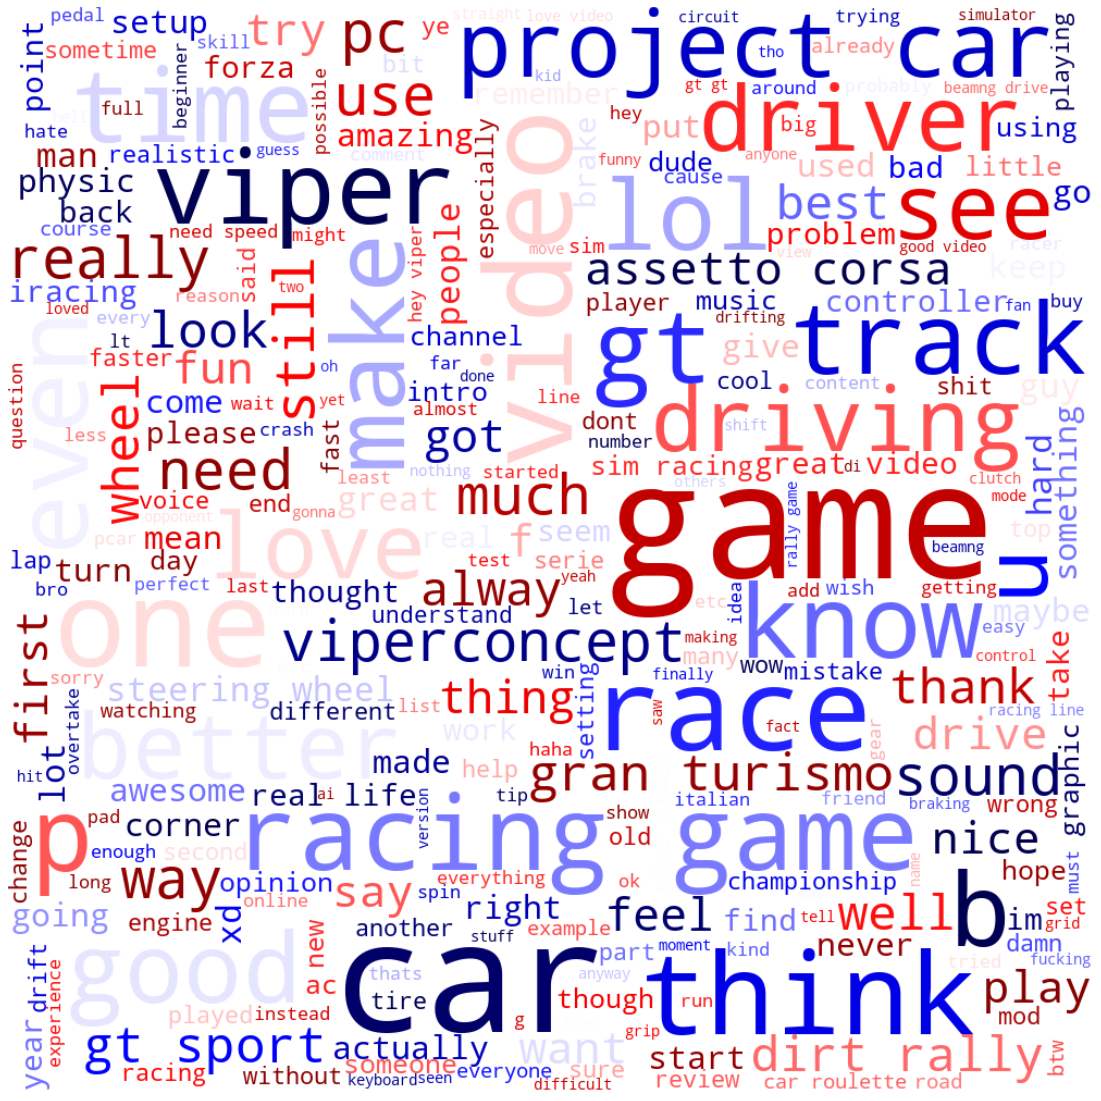

In [46]:
params = dict(width = 1000,
      height = 1000,
      max_font_size = 150,
      max_words = 300,
      background_color = 'white',
      colormap = 'seismic')

make_word_cloud(comments, **params)

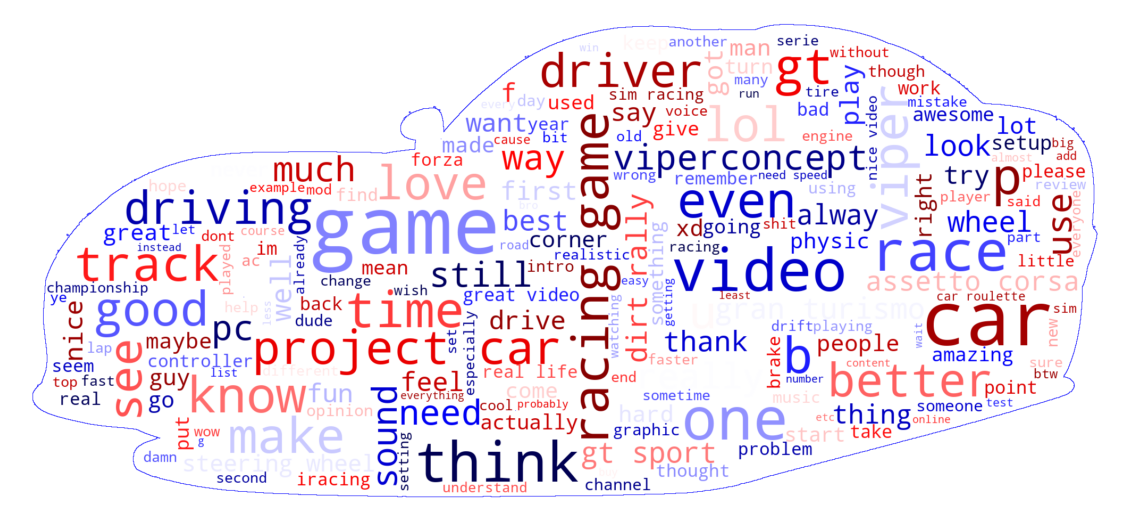

In [49]:
img = PIL.Image.open("../datasets/dodgeVip.png")
mask = np.array(img)

params = dict(width = 1600,
    height = 800,
    max_font_size = 150,
    max_words = 200,
    background_color = 'white',
    colormap = 'seismic',
    mask = mask,
    contour_width = .02,
    contour_color = 'blue')

make_word_cloud(comments, **params)

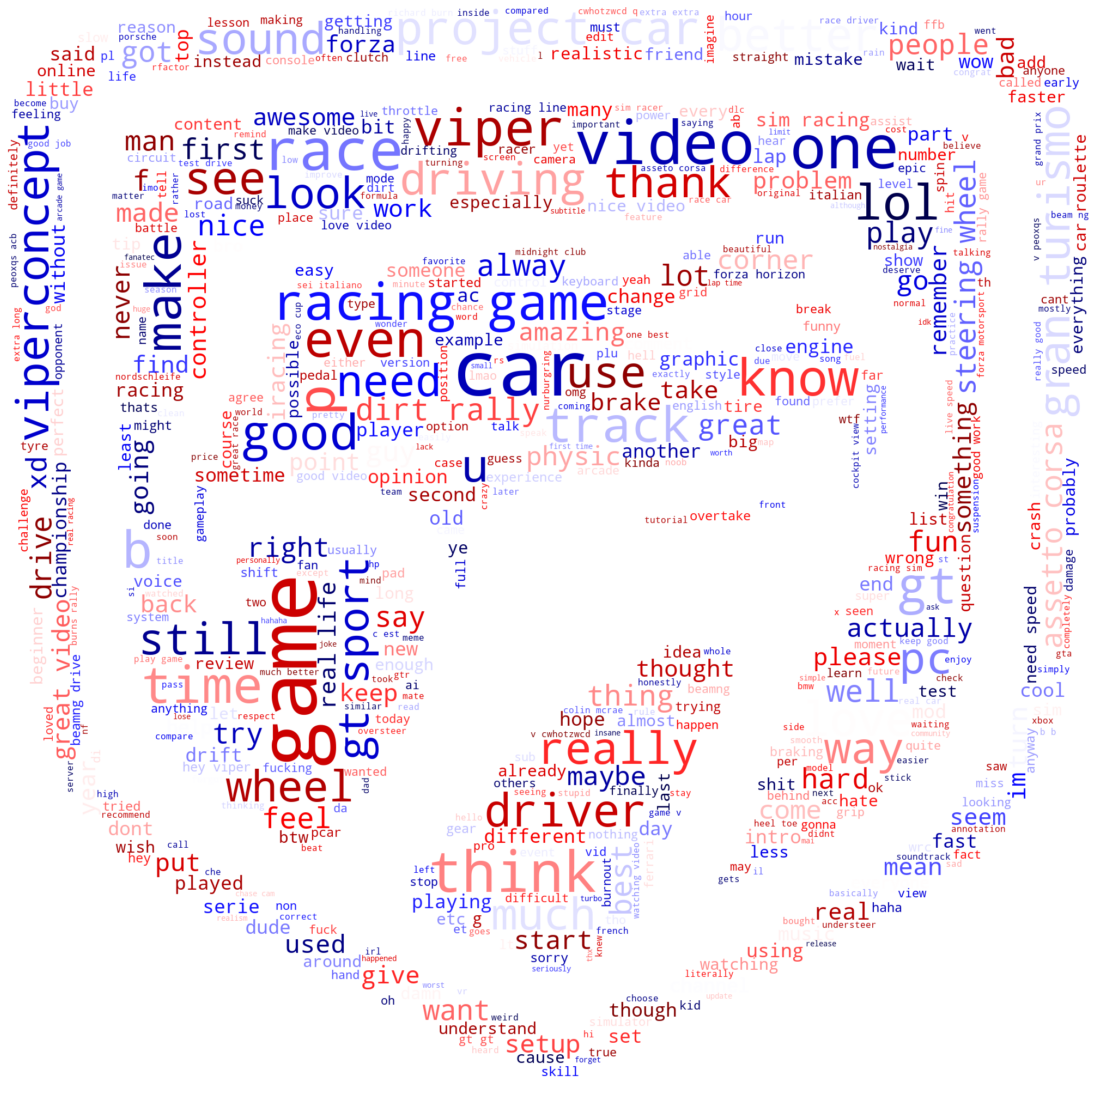

In [48]:
img = PIL.Image.open("../datasets/logoDV.png")
mask = np.array(img)
params = dict(width = 1600,
    height = 1600,
    max_font_size = 150,
    max_words = 600,
    background_color = 'white',
    colormap = 'seismic',
    mask = mask,
    contour_width = 0,
    contour_color = 'blue')

make_word_cloud(comments, **params)